https://github.com/babylm/evaluation-pipeline-2025?tab=readme-ov-file

BabyLM-community/babylm-baseline-100m-gpt2
BabyLM-community/babylm-interaction-baseline-simpo

./eval_zero_shot_fast.sh <path_to_model> <revision_name> <architecture (causal/mntp/mlm)> <eval_dir (optional, default:evaluation_data/fast_eval)>

./eval_zero_shot.sh <path_to_model> <architecture (causal/mntp/mlm)> <eval_dir (optional, default:evaluation_data/full_eval)>

./eval_finetune.sh <path_to_model> <learning_rate (optional, default: 3e-5)> <batch_size (optional, default: 32)> <max_epochs (optional, default: 10)> <seed (optional, default: 42)>

huggingface-cli login


BabyLM-community/babylm-interaction-baseline-simpo


```./eval_zero_shot_fast.sh BabyLM-community/babylm-baseline-100m-gpt2 chck_1000M causal```

```./eval_zero_shot_fast.sh BabyLM-community/babylm-interaction-baseline-simpo chck_1000M causal```

```./eval_zero_shot_fast.sh llm-slice/babylm-gpt2-small-90M-seed42 chck_1000M causal```

```./eval_finetuning.sh Babylm-community/babylm-baseline-100m-gpt2 3e-5 32 10 42```

 ./eval_finetuning.sh BabyLM-community/babylm-baseline-100m-gpt2 3e-5 32 16 10 chck_1000M 42

## Visualization

## Plot final checkpoint evaluation for baseline (GPT2-small_chck_1000M) and RL model
#### Read results from finetuning

In [4]:
# Plotting util functions

def init_latex(fontsize):
    # LaTeX fonts, paper figure sizing utilities
    os.environ['PATH'] += os.pathsep + '/Library/TeX/texbin'
    plt.rcParams.update({
        "text.usetex": True,
        "font.family": "serif",
        "axes.labelsize": fontsize,
        "font.size": fontsize,
        "legend.fontsize": fontsize,
        "xtick.labelsize": fontsize,
        "ytick.labelsize": fontsize,
    })

def set_size(width_pt, fraction=1, aspect_ratio=None):
    fig_width_pt = width_pt * fraction
    cm_per_pt = 1 / 72.27 * 2.54
    if aspect_ratio is None:
        ratio = (5**.5 - 1) / 2  # Golden ratio
    fig_width_cm = width_pt * cm_per_pt * fraction
    fig_height_cm = fig_width_cm * aspect_ratio
    return (fig_width_cm, fig_height_cm)

## Plot fast evals

Probably split by task and then show all models in each subplot: baselines (GPT2-small, SimPO) and all the PPO variants (with more dense checkpoints than suggested for the RL part, again 1M, 2M, ..., 10M, 20M, ...)

In [9]:
import os
import re
import pandas as pd

def extract_results_from_file(file_path, scenario):
    print(f"[INFO] Extracting from: {file_path} | scenario: {scenario}")
    try:
        with open(file_path, 'r') as file:
            content = file.read()
    except Exception as e:
        print(f"[ERROR] Could not read file: {file_path} -- {e}")
        return {}
    results = {}
    if scenario == 'ewok_fast':
        temperature_match = re.search(r'TEMPERATURE: ([\d.]+)', content)
        if temperature_match:
            results['temperature'] = float(temperature_match.group(1))
        avg_acc = re.search(r'AVERAGE ACCURACY\n([\d.]+)', content)
        if avg_acc:
            results['average_accuracy'] = float(avg_acc.group(1))
    elif scenario == 'reading':
        correlations_file = file_path
        report_file = os.path.join(os.path.dirname(file_path), 'report.txt')
        if os.path.exists(report_file):
            with open(report_file, 'r') as report_file_obj:
                report_content = report_file_obj.read()
                eye_tracking_score_match = re.search(r'EYE TRACKING SCORE:\s+([\d.]+)', report_content)
                selfpaced_reading_score_match = re.search(r'SELF-PACED READING SCORE:\s+([\d.]+)', report_content)
                if eye_tracking_score_match:
                    results['eye_tracking_score'] = float(eye_tracking_score_match.group(1))
                if selfpaced_reading_score_match:
                    results['selfpaced_reading_score'] = float(selfpaced_reading_score_match.group(1))
    else:
        temperature_match = re.search(r'TEMPERATURE: ([\d.]+)', content)
        if temperature_match:
            results['temperature'] = float(temperature_match.group(1))
        avg_acc = re.search(r'AVERAGE ACCURACY\n([\d.]+)', content)
        if avg_acc:
            results['average_accuracy'] = float(avg_acc.group(1))
        if scenario == 'blimp_fast':
            # Locate the FIELD ACCURACY block
            field_acc_block = re.search(r'### FIELD ACCURACY\s*(.*?)(?:\n\n|$)', content, re.DOTALL)
            if field_acc_block:
                block = field_acc_block.group(1)
                # Extract lines like: syntax: 68.17
                for line in block.splitlines():
                    m = re.match(r'\s*([a-zA-Z/_]+):\s*([\d.]+)', line)
                    if m:
                        key = f"field_accuracy_{m.group(1).replace('/', '_')}"
                        results[key] = float(m.group(2))
    print(f"[INFO] Results extracted: {results}")
    return results

def extract_results_all_models(results_dir):
    print(f"[INFO] Scanning base dir: {results_dir}")
    rows = []
    subtask_scenario_map = {
        'blimp': ['blimp_fast', 'supplement_fast'],
        'entity_tracking': ['entity_tracking_fast'],
        'ewok': ['ewok_fast'],
        'reading': [],
        'wug': ['wug_adj_nominalization']
    }
    for model_name in sorted(os.listdir(results_dir)):
        model_dir = os.path.join(results_dir, model_name)
        if model_name.startswith('.') or not os.path.isdir(model_dir):
            continue
        print(f"[INFO] Processing model: {model_name}")
        revisions = [rev for rev in os.listdir(model_dir) if not rev.startswith('.')]
        for revision in revisions:
            revision_dir = os.path.join(model_dir, revision, 'zero_shot', 'causal')
            if not os.path.isdir(revision_dir):
                print(f"[WARN] Revision dir missing: {revision_dir}")
                continue
            for subtask, scenarios in subtask_scenario_map.items():
                subtask_dir = os.path.join(revision_dir, subtask)
                if not os.path.isdir(subtask_dir):
                    print(f"[WARN] Subtask dir missing: {subtask_dir}")
                    continue
                if subtask == 'reading':
                    correlations_file = os.path.join(subtask_dir, 'correlations.txt')
                    if not os.path.exists(correlations_file):
                        print(f"[WARN] No correlations file at {correlations_file}")
                        continue
                    results = extract_results_from_file(correlations_file, 'reading')
                    row = {
                        'model_name': model_name,
                        'revision': revision,
                        'scenario': 'reading'
                    }
                    row.update(results)
                    rows.append(row)
                else:
                    for scenario in scenarios:
                        scenario_dir = os.path.join(subtask_dir, scenario)
                        if not os.path.isdir(scenario_dir):
                            print(f"[WARN] Scenario dir missing: {scenario_dir}")
                            continue
                        file_path = os.path.join(scenario_dir, 'best_temperature_report.txt')
                        if not os.path.exists(file_path):
                            print(f"[WARN] Missing file: {file_path}")
                            continue
                        results = extract_results_from_file(file_path, scenario)
                        row = {
                            'model_name': model_name,
                            'revision': revision,
                            'scenario': scenario
                        }
                        row.update(results)
                        rows.append(row)
    df = pd.DataFrame(rows)
    # Extract and check revision_number
    df['revision_number'] = (
        df['revision']
          .str.extract(r'(\d+)')
          .astype(float)
    )
    bad_mask = df['revision_number'].isnull()
    if bad_mask.any():
        print(f"[WARN] Found {bad_mask.sum()} row(s) with bad/missing revision_number. These rows will be dropped.")
        print(df.loc[bad_mask, ['model_name', 'revision']])
        df = df.loc[~bad_mask].copy()
    df['revision_number'] = df['revision_number'].astype(int)
    print(f"[INFO] Extracted {len(df)} rows. Columns: {df.columns.tolist()}")
    return df

# Usage: extract results, save as pickle
results_dir = "babylm_eval/results"
df = extract_results_all_models(results_dir)
df.to_pickle('results_long.pkl')
print("[INFO] DataFrame saved to results_long.pkl")

[INFO] Scanning base dir: babylm_eval/results
[INFO] Processing model: babylm-baseline-100m-gpt2
[INFO] Extracting from: babylm_eval/results/babylm-baseline-100m-gpt2/chck_800M/zero_shot/causal/blimp/blimp_fast/best_temperature_report.txt | scenario: blimp_fast
[INFO] Results extracted: {'temperature': 1.0, 'average_accuracy': 75.07, 'field_accuracy_syntax': 71.58, 'field_accuracy_morphology': 88.19, 'field_accuracy_syntax_semantics': 69.86, 'field_accuracy_semantics': 67.0}
[INFO] Extracting from: babylm_eval/results/babylm-baseline-100m-gpt2/chck_800M/zero_shot/causal/blimp/supplement_fast/best_temperature_report.txt | scenario: supplement_fast
[INFO] Results extracted: {'temperature': 1.0, 'average_accuracy': 62.8}
[INFO] Extracting from: babylm_eval/results/babylm-baseline-100m-gpt2/chck_800M/zero_shot/causal/entity_tracking/entity_tracking_fast/best_temperature_report.txt | scenario: entity_tracking_fast
[INFO] Results extracted: {'temperature': 1.0, 'average_accuracy': 31.7}
[INF

- **BoolQ** &nbsp; — Boolean Questions
- **MultiRC** &nbsp; — Multi-sentence Reading Comprehension ([arXiv:2410.15997](https://arxiv.org/abs/2410.15997))
- **RTE** &nbsp; — GLUE inference: Recognizing Textual Entailment
- **MRPC** &nbsp; — GLUE similarity and paraphrase: Microsoft Research Paraphrase Corpus
- **QQP** &nbsp; — GLUE similarity and paraphrase: Quora Question Pairs
- **MNLI** &nbsp; — GLUE inference: Multi-Genre Natural Language Inference

Tentative conclusions:
1. Both model suspiciously similar: If the SimPO model were entirely RL-trained that would be highly surprising. Perhaps this shows that the weaker $0.2$ portion of next-level prediction is sufficient and carries the model training, whereas the RL is redundant?
2. BLiMP and BLiMP supplement improve over training
3. Entity tracking and WUG Test get worse
4. EWOK is random baseline
5. Reading is constant

#### BLiMP fields

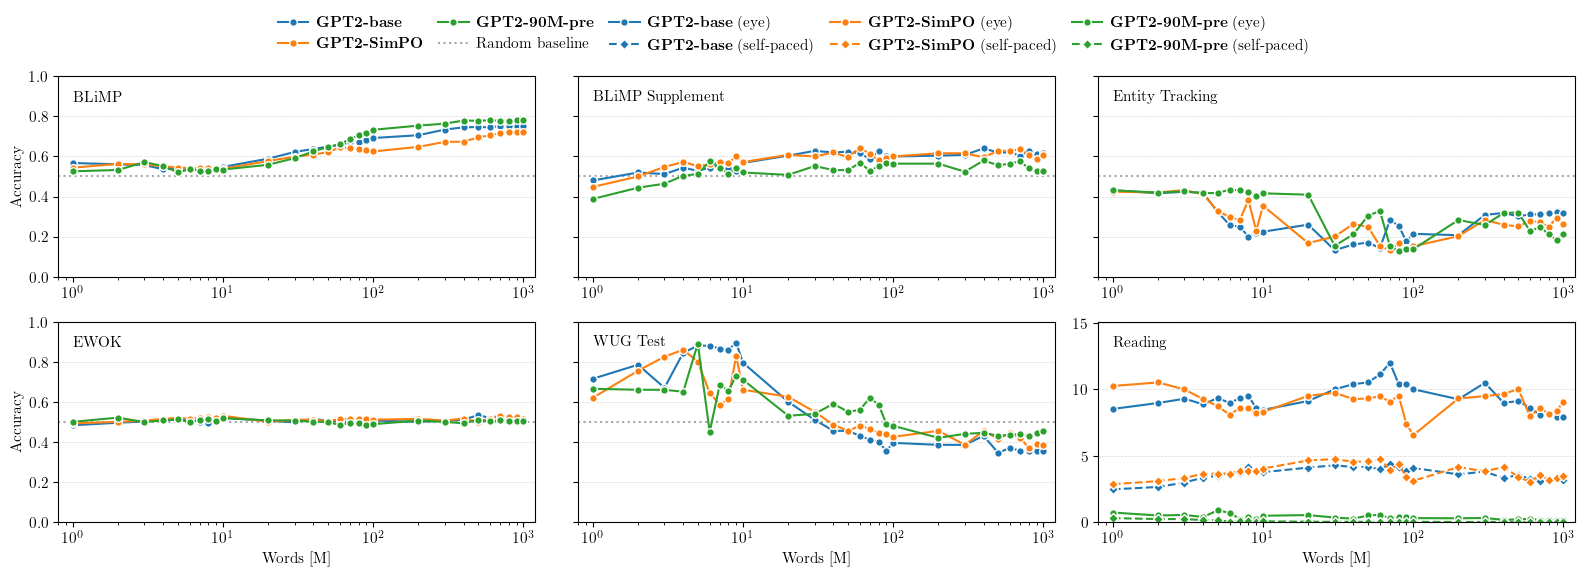

In [37]:
import matplotlib.pyplot as plt
import numpy as np
import os
from matplotlib.ticker import LogLocator

# Font config
fontsize = 11
init_latex(fontsize)

MODEL_DISPLAY = {
    'babylm-baseline-100m-gpt2': r"\textbf{GPT2-base}",
    'babylm-interaction-baseline-simpo': r"\textbf{GPT2-SimPO}",
    'babylm-gpt2-small-90M-seed41': r"\textbf{GPT2-90M-pre}",
}
MODEL_COLORS = {
    'babylm-baseline-100m-gpt2': "tab:blue",
    'babylm-interaction-baseline-simpo': "tab:orange",
    'babylm-gpt2-small-90M-seed41': "tab:green",
}
TASK_DISPLAY = {
    "blimp_fast": "BLiMP",
    "supplement_fast": "BLiMP Supplement",
    "entity_tracking_fast": "Entity Tracking",
    "ewok_fast": "EWOK",
    "wug_adj_nominalization": "WUG Test",
    "reading": "Reading",
    "BoolQ": "BoolQ",
    "MultiRC": "MultiRC",
    "RTE": "RTE",
    "MRPC": "MRPC",
    "QQP": "QQP",
    "MNLI": "MNLI"
}

# Place panels: ...3 col by 2 row grid, with reading always bottom-right, wug always bottom-middle
MAIN_TASKS = [t for t in df['scenario'].unique()
              if t not in ["reading", "wug_adj_nominalization"]]
# Sort for aesthetics
panel_order = MAIN_TASKS[:4] + ["wug_adj_nominalization", "reading"]
n_tasks = len(panel_order)
n_cols = 3
n_rows = int(np.ceil(n_tasks / n_cols))
markersize = 5.5
mec = "white" # markeredgecolor

width_pt = 455.2
figsize = set_size(width_pt, fraction=1, aspect_ratio=0.33)
fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize)
axes = axes.flatten()

for idx, task in enumerate(panel_order):
    ax = axes[idx]
    task_df = df[df['scenario'] == task]
    plotted_any = False

    if task == "reading":
        # Bottom right: plot both scores, different symbols/same color per model
        #for model_name in task_df['model_name'].unique():
        for model_name in MODEL_DISPLAY.keys():
            dfm = task_df[task_df['model_name'] == model_name].sort_values('revision_number')
            x = dfm['revision_number'].values
            y_eye = dfm['eye_tracking_score'].values if 'eye_tracking_score' in dfm.columns else []
            y_self = dfm['selfpaced_reading_score'].values if 'selfpaced_reading_score' in dfm.columns else []
            label_base = MODEL_DISPLAY.get(model_name, model_name)
            color = MODEL_COLORS.get(model_name, None)
            if len(x) and len(y_eye):
                ax.plot(x, y_eye, color=color, marker='o', markersize=markersize, label=f"{label_base} (eye)", linestyle='-', mec=mec)
                plotted_any = True
            if len(x) and len(y_self):
                ax.plot(x, y_self, color=color, marker='D', markersize=markersize, label=f"{label_base} (self-paced)", linestyle='--', mec=mec)
                plotted_any = True
        #ax.set_ylabel('Reading Score')
        ax.set_ylim(0, 15.1)
    elif task == "wug_adj_nominalization":
        for model_name in MODEL_DISPLAY.keys():
            dfm = task_df[task_df['model_name'] == model_name].sort_values('revision_number')
            x = dfm['revision_number'].values
            y = (dfm['average_accuracy'].values) / 100
            if len(x) and len(y):
                label = MODEL_DISPLAY.get(model_name, model_name)
                color = MODEL_COLORS.get(model_name, None)
                ax.plot(x, y, color=color, marker='o', markersize=markersize, label=label, mec=mec)
                plotted_any = True
        if plotted_any:
            ax.axhline(y=0.5, ls=':', color='gray', alpha=0.7, label="Random baseline", zorder=0)
        ax.set_ylabel('Accuracy' if idx % n_cols == 0 else "")
        ax.set_ylim(0, 1)
        if idx % n_cols != 0:
            ax.set_yticklabels([])
    else:
        for model_name in MODEL_DISPLAY.keys():
            dfm = task_df[task_df['model_name'] == model_name].sort_values('revision_number')
            x = dfm['revision_number'].values
            y = (dfm['average_accuracy'].values) / 100
            if len(x) and len(y):
                label = MODEL_DISPLAY.get(model_name, model_name)
                color = MODEL_COLORS.get(model_name, None)
                ax.plot(x, y, color=color, marker='o', markersize=markersize, label=label, mec=mec)
                plotted_any = True
        if plotted_any:
            ax.axhline(y=0.5, ls=':', color='gray', alpha=0.7, label="Random baseline", zorder=0)
        ax.set_ylabel('Accuracy' if idx % n_cols == 0 else "")
        ax.set_ylim(0, 1)
        if idx % n_cols != 0:
            ax.set_yticklabels([])

    # X label handling
    if idx // n_cols == n_rows - 1:
        ax.set_xlabel(r'Words [M]')
    else:
        ax.set_xlabel("")
        ax.set_xticklabels([])

    # X axis log, range & gridlines for all panels
    ax.set_xscale('log')
    ax.set_xlim(0.8, 1200)
    ax.xaxis.set_major_locator(LogLocator(base=10.0))
    ax.xaxis.set_minor_locator(LogLocator(base=10.0, subs=(0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9)))
    ax.grid(axis='y', color='gray', linestyle='--', linewidth=0.5, alpha=0.3)
    ax.set_axisbelow(True)
    display_title = TASK_DISPLAY.get(task, str(task))
    ax.text(
        0.03, 0.93, display_title,
        fontsize=fontsize, weight="bold", ha="left", va="top", transform=ax.transAxes,
        bbox=dict(facecolor='white', edgecolor='none', boxstyle='round,pad=0.2', alpha=0.7)
    )

# Remove unused axes if any
for ax in axes[n_tasks:]:
    ax.axis('off')

# Create legend only with unique handles/labels
handles = []
labels = []
for ax in axes:
    for h, l in zip(*ax.get_legend_handles_labels()):
        if l not in labels:
            handles.append(h)
            labels.append(l)
if handles:
    fig.legend(handles, labels, loc='upper center', ncol=5, frameon=False,
               handletextpad=0.5, columnspacing=1.0, bbox_to_anchor=(0.5, 1.1))

#fig.text(
#    0.334, 0.12, r'$\times 10^6$',
#    ha='right', va='bottom',
#    fontsize=fontsize,
#    color='black'
#)
#fig.text(
#    0.656, 0.12, r'$\times 10^6$',
#    ha='right', va='bottom',
#    fontsize=fontsize,
#    color='black'
#)
#fig.text(
#    0.984, 0.12, r'$\times 10^6$',
#    ha='right', va='bottom',
#    fontsize=fontsize,
#    color='black'
#)

plt.tight_layout()
plt.savefig("figs/BLM_eval_fast.pdf")
plt.show()

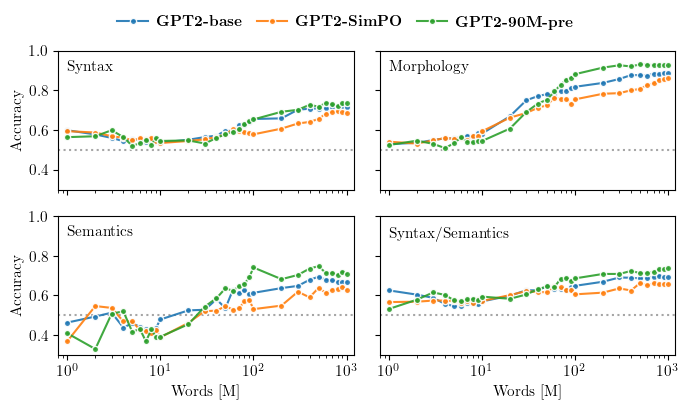

In [33]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import LogLocator

fontsize = 11
init_latex(fontsize)

# List and display names of BLiMP fields
blimp_fields = [
    'field_accuracy_syntax',
    'field_accuracy_morphology',
    'field_accuracy_semantics',
    'field_accuracy_syntax_semantics'
]
field_labels = [
    'Syntax', 'Morphology', 'Semantics', 'Syntax/Semantics'
]
field_display_map = dict(zip(blimp_fields, field_labels))

model_names = MODEL_DISPLAY.keys()
markersize = 4.5
mec = "1.0"

fig_width_pt = 200
figsize = set_size(fig_width_pt, fraction=1, aspect_ratio=0.55)
fig, axes = plt.subplots(2, 2, figsize=figsize)
axes = axes.flatten()

linestyles = ['-', '-', '-', '-']

for fidx, (field, field_label) in enumerate(zip(blimp_fields, field_labels)):
    ax = axes[fidx]
    for midx, model_name in enumerate(model_names):
        blimp_df = df[(df['scenario'] == 'blimp_fast') & (df['model_name'] == model_name)].sort_values('revision_number')
        if field in blimp_df.columns:
            x = blimp_df['revision_number']
            y = blimp_df[field].values / 100.0
            if len(x) and len(y):
                label = MODEL_DISPLAY.get(model_name, model_name)
                color = MODEL_COLORS.get(model_name, None)
                ax.plot(
                    x, y,
                    label=label,
                    color=color,
                    linestyle=linestyles[midx % len(linestyles)],
                    marker='o',
                    markersize=markersize,
                    mec=mec,
                    alpha=0.9
                )
    ax.axhline(y=0.5, ls=':', color='gray', alpha=0.7, label=None, zorder=0)
    ax.set_ylim(0.3, 1.00)
    # Internal title on the top-left
    ax.text(
        0.03, 0.93, field_label,
        fontsize=fontsize, weight="bold", ha="left", va="top", transform=ax.transAxes,
        bbox=dict(facecolor='white', edgecolor='none', boxstyle='round,pad=0.2', alpha=0.7)
    )
    ax.set_xscale('log')
    ax.set_xlim(0.8, 1200)
    ax.xaxis.set_major_locator(LogLocator(base=10.0))
    ax.xaxis.set_minor_locator(LogLocator(base=10.0, subs=(0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9)))
    #ax.grid(axis='y', color='gray', linestyle='--', linewidth=0.5, alpha=0.3)
    ax.set_axisbelow(True)
    if fidx % 2 == 0:
        ax.set_ylabel('Accuracy')
    else:
        ax.set_yticklabels([])
    if fidx // 2 == 1:
        ax.set_xlabel(r'Words [M]')
    else:
        ax.set_xticklabels([])

# Remove any unused axes
for f in range(len(blimp_fields), len(axes)):
    axes[f].axis('off')

# Put joint legend at top center, outside grid
handles, labels = axes[0].get_legend_handles_labels()
from collections import OrderedDict
by_label = OrderedDict(zip(labels, handles))
fig.legend(
    by_label.values(),
    by_label.keys(),
    loc='upper center',
    ncol=len(by_label),
    frameon=False,
    handletextpad=0.5,
    columnspacing=1.0,
    bbox_to_anchor=(0.5, 1.07)
)
#fig.text(
#    0.504, 0.17, r'$\times 10^6$',
#    ha='right', va='bottom',
#    fontsize=fontsize,
#    color='black'
#)
#fig.text(
#    0.964, 0.17, r'$\times 10^6$',
#    ha='right', va='bottom',
#    fontsize=fontsize,
#    color='black'
#)

plt.tight_layout(rect=[0, 0, 1, 1])
plt.savefig("figs/BLM_eval_fast_BLiMP_fields.pdf")
plt.show()

#### Load Wandb runs for GLUE finetuning

In [1]:
WANDB_PROJECT="BLM_eval_finetuning"
WANDB_ENTITY="jonas-mayermartins-university-of-goettingen"

In [5]:
import wandb
import pandas as pd  # Needed for df

# Color by model
MODEL_COLORS = {
    "gpt2-base": "tab:blue",
    "gpt2-simpo": "tab:orange",
    "gpt2-90M-pre": "tab:green",
    "gpt2-90M-ppo": "tab:red",
}

# Run mapping: run_id -> (task_label, model_label, color)
run_info = {
    # GPT2-base (blue, babylm-baseline-100m-gpt2 chck_1000M causal)
    "sdn52gud": ("\\textbf{BoolQ}", "gpt2-base", MODEL_COLORS["gpt2-base"]),           # Boolean Questions
    "t0ctufpk": ("\\textbf{MultiRC}", "gpt2-base", MODEL_COLORS["gpt2-base"]),         # Multi-sentence Reading Comprehension
    "jz88029a": ("\\textbf{RTE}", "gpt2-base", MODEL_COLORS["gpt2-base"]),             # GLUE inference: Recognizing Textual Entailment
    "m3511x7c": ("\\textbf{MRPC}", "gpt2-base", MODEL_COLORS["gpt2-base"]),            # GLUE similarity and paraphrase: Microsoft Research Paraphrase Corpus
    "et93fc2i": ("\\textbf{QQP}", "gpt2-base", MODEL_COLORS["gpt2-base"]),             # GLUE similarity and paraphrase: Quora Question Pairs
    "ii86bwdx": ("\\textbf{MNLI}", "gpt2-base", MODEL_COLORS["gpt2-base"]),            # GLUE inference: Multi-Genre Natural Language Inference

    # GPT2-SimPO (orange, babylm-interaction-baseline-simpo chck_1000M causal)
    "7wqfbbno": ("\\textbf{BoolQ}", "gpt2-simpo", MODEL_COLORS["gpt2-simpo"]),             # Boolean Questions
    "jm3bs8wi": ("\\textbf{MultiRC}", "gpt2-simpo", MODEL_COLORS["gpt2-simpo"]),           # Multi-sentence Reading Comprehension
    "fsppjjb5": ("\\textbf{RTE}", "gpt2-simpo", MODEL_COLORS["gpt2-simpo"]),               # GLUE inference: Recognizing Textual Entailment
    "xkrxziyt": ("\\textbf{MRPC}", "gpt2-simpo", MODEL_COLORS["gpt2-simpo"]),              # GLUE similarity and paraphrase: Microsoft Research Paraphrase Corpus
    "mv9dpmrp": ("\\textbf{QQP}", "gpt2-simpo", MODEL_COLORS["gpt2-simpo"]),               # GLUE similarity and paraphrase: Quora Question Pairs
    "7vuft57i": ("\\textbf{MNLI}", "gpt2-simpo", MODEL_COLORS["gpt2-simpo"]),              # GLUE inference: Multi-Genre Natural Language Inference

    # Seed 41 GPT2-pretrain (green, babylm-interaction-baseline-simpo chck_900M causal)
    "26ccswxv": ("\\textbf{BoolQ}", "gpt2-90M-pre", MODEL_COLORS["gpt2-90M-pre"]),             # Boolean Questions
    "u1mllgay": ("\\textbf{MultiRC}", "gpt2-90M-pre", MODEL_COLORS["gpt2-90M-pre"]),           # Multi-sentence Reading Comprehension
    "mly9b0zr": ("\\textbf{RTE}", "gpt2-90M-pre", MODEL_COLORS["gpt2-90M-pre"]),               # GLUE inference: Recognizing Textual Entailment
    "stwp4qts": ("\\textbf{MRPC}", "gpt2-90M-pre", MODEL_COLORS["gpt2-90M-pre"]),              # GLUE similarity and paraphrase: Microsoft Research Paraphrase Corpus
    "iyfjzsp7": ("\\textbf{QQP}", "gpt2-90M-pre", MODEL_COLORS["gpt2-90M-pre"]),               # GLUE similarity and paraphrase: Quora Question Pairs
    "pv6gqn0x": ("\\textbf{MNLI}", "gpt2-90M-pre", MODEL_COLORS["gpt2-90M-pre"]),              # GLUE inference: Multi-Genre Natural Language Inference

    # Seed 42 GPT2-pretrain (green, babylm-interaction-baseline-simpo chck_900M causal)
    #"2pp9tyvo": ("\\textbf{BoolQ}", "gpt2-90M-pre", MODEL_COLORS["gpt2-90M-pre"]),             # Boolean Questions
    #"6p9x3p89": ("\\textbf{MultiRC}", "gpt2-90M-pre", MODEL_COLORS["gpt2-90M-pre"]),           # Multi-sentence Reading Comprehension
    #"wbxtfrew": ("\\textbf{RTE}", "gpt2-90M-pre", MODEL_COLORS["gpt2-90M-pre"]),               # GLUE inference: Recognizing Textual Entailment
    #"nbk8imph": ("\\textbf{MRPC}", "gpt2-90M-pre", MODEL_COLORS["gpt2-90M-pre"]),              # GLUE similarity and paraphrase: Microsoft Research Paraphrase Corpus
    #"34nfa31v": ("\\textbf{QQP}", "gpt2-90M-pre", MODEL_COLORS["gpt2-90M-pre"]),               # GLUE similarity and paraphrase: Quora Question Pairs
    #"uh8i4mom": ("\\textbf{MNLI}", "gpt2-90M-pre", MODEL_COLORS["gpt2-90M-pre"]),              # GLUE inference: Multi-Genre Natural Language Inference
}
accuracy = {} # Dict to store histories for each

# Download/prepare all histories first
for run_id, (task, model_label, color) in run_info.items():
    api = wandb.Api()
    run = api.run(f"{WANDB_ENTITY}/{WANDB_PROJECT}/{run_id}")
    all_rows = [row for row in run.scan_history()]
    if not all_rows:
        continue
    history = pd.DataFrame(all_rows)
    accuracy[run_id] = (task, model_label, color, history)

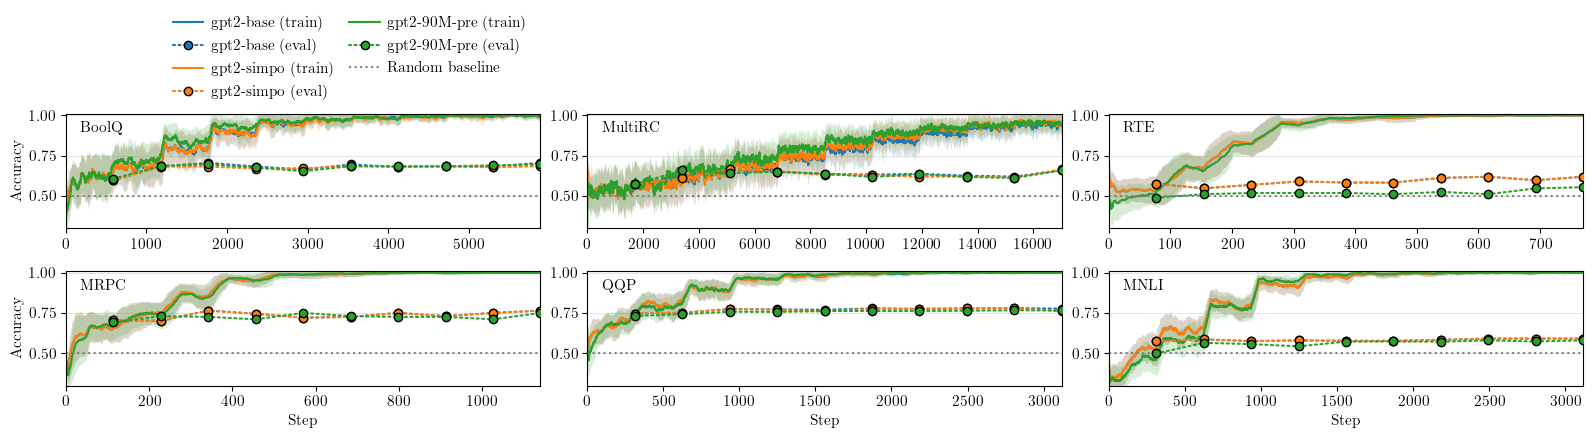

In [32]:
import matplotlib.pyplot as plt
import numpy as np
import os
from collections import defaultdict

roll_avg_window = 50
mec = "black"
fontsize = 11

init_latex(fontsize)

# Group run_ids by task
# task_name -> [(model_label, color, history_df)]

task_runs = defaultdict(list)
for run_id, (task, model_label, color, history) in accuracy.items():
    # Un-LaTeX the task name for grouping
    task_name = task.replace("\\textbf{", "").replace("}", "")
    task_runs[task_name].append((model_label, color, history))

tasks = ["BoolQ", "MultiRC", "RTE", "MRPC", "QQP", "MNLI"]

width_pt = 455.2
figsize = set_size(width_pt, aspect_ratio=0.15)
fig, axes = plt.subplots(2, 3, figsize=(figsize[0], figsize[1] * 2/3 * 3))  # 6 subplots

for idx, task in enumerate(tasks):
    r, c = divmod(idx, 3)
    ax = axes[r, c]
    runs = task_runs[task]
    for model_label, color, history in runs:
        steps = history["_step"]
        train = history["train/accuracy"]

        # REMOVE THE TRACE OF TRAINING:
        # h1, = ax.plot(steps, train, color=color, alpha=0.1)

        # Compute rolling mean (centered by default in pandas)
        smoothed = train.rolling(roll_avg_window, min_periods=1).mean()
        ax.plot(steps, smoothed, color=color, label=f"{model_label} (train)")

        # Rolling standard deviation
        rolling_std = train.rolling(roll_avg_window, min_periods=1).std()
        lower = smoothed - rolling_std
        upper = smoothed + rolling_std

        ax.fill_between(
            steps, lower, upper,
            color=color, alpha=0.18, linewidth=0,
            label=None
        )

        eval_acc = history["evaluate/accuracy"]
        mask = eval_acc.notnull()
        eval_steps = steps[mask]
        eval_vals = eval_acc[mask]
        (line,) = ax.plot(eval_steps, eval_vals, color=color, linestyle=":",
                marker="o", markeredgecolor=mec, label=f"{model_label} (eval)", zorder = 5)
        line.set_dash_capstyle("round")
    ax.hlines(y=0.5, xmin=0, xmax=max(eval_steps), linestyle=":", color="gray", label='Random baseline')

    # Legends (just on first subplot)
    if idx == 0:
        handles, labels = ax.get_legend_handles_labels()
        ax.legend(handles, labels, loc='lower right', ncol=2, frameon=False, handletextpad=0.5, columnspacing=1.0, bbox_to_anchor=(1, 1.))

    ax.text(0.03, 0.93, task, fontsize=fontsize, weight="bold", ha="left", va="top", transform=ax.transAxes,
            bbox=dict(facecolor='white', edgecolor='none', boxstyle='round,pad=0.2', alpha=0.5))

    if c == 0:
        ax.set_ylabel("Accuracy")
    else:
        ax.set_ylabel("")
    if r == 1:
        ax.set_xlabel("Step")
    else:
        ax.set_xlabel("")

    ax.grid(axis='y', color='gray', linestyle='-', linewidth=0.5, alpha=0.3)
    ax.set_axisbelow(True)
    ax.set_xlim(0, np.max(eval_steps))
    ax.set_ylim(0.3,1.01)

plt.tight_layout(rect=[0, 0.03, 1, 0.97])
plt.savefig("figs/BLM_eval_finetune.pdf")
plt.show()

This for each model in the appendix. (Perhaps combine all models into one plot).
In the main body, show only final eval result.





---



---